# 11-Year Mortality Probability Prediction Capstone Project

Importing all of the packages we will be utilizing in this notebook for data loading, processing, analyzing, modeling and visualizing. You will need to pip install such additional packages in order to be able to perform run the code:
- lifelines
- imbalanced-learn
- yellowbrick
- plotly

In [2]:
import pandas as pd
import pickle
%matplotlib inline
import matplotlib as mpl
mpl.style.use('seaborn-white')
from cycler import cycler
import numpy as np
import seaborn as sns
from time import time
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn.feature_selection import (SelectKBest, SelectFromModel)
from sklearn.svm import LinearSVC
from sklearn.feature_selection import (chi2, RFE)
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn.metrics import (auc, roc_curve, recall_score, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score)
from sklearn.linear_model import (LogisticRegression, LogisticRegressionCV, RidgeClassifier, Ridge, Lasso, ElasticNet)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, RandomTreesEmbedding,GradientBoostingClassifier)
import lifelines as ll
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from matplotlib.pyplot import figure
from matplotlib.pyplot import NullFormatter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
from ipywidgets import widgets
from collections import Counter
import statsmodels.formula.api as sm
from imblearn.combine import (SMOTEENN, SMOTETomek)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.metrics import sensitivity_specificity_support
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.features.importances import FeatureImportances

Setting some visual preferences.

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Dataset which we are using in this project was a cortesy of National Heart, Lung and Blood Institute (https://biolincc.nhlbi.nih.gov/home/), which was provided to the team upon individual request and had to be downloaded manually from a secured account created for that purpose.

In [4]:
dataset = pd.read_csv('11.csv')

In [5]:
dataset.head()

,record,age,race,sex,ms,hisp,adjinc,educ,pob,wt,...,tenure,citizen,health,indalg,smok100,agesmk,smokstat,smokhome,curruse,everuse
0,88426,70,1.0,2,5.0,3.0,11.0,4.0,909,151,...,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,88427,79,1.0,2,2.0,3.0,11.0,4.0,909,132,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,88428,34,1.0,1,1.0,3.0,8.0,4.0,909,155,...,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,88429,32,1.0,2,1.0,3.0,8.0,1.0,909,155,...,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,88430,2,1.0,2,NaN,3.0,8.0,NaN,909,145,...,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


Dropping some columns related to tobacco use due to missing data.

In [6]:
df = dataset.drop(['smok100', 'agesmk', 'wt', 'smokstat', 'smokhome', 'curruse', 'everuse', 'indalg'], axis=1)
df.columns

Index(['record', 'age', 'race', 'sex', 'ms', 'hisp', 'adjinc', 'educ', 'pob',
       'hhid', 'hhnum', 'reltrf', 'occ', 'majocc', 'ind', 'majind', 'esr',
       'urban', 'smsast', 'inddea', 'cause113', 'follow', 'dayod', 'hosp',
       'hospd', 'ssnyn', 'vt', 'histatus', 'hitype', 'povpct', 'stater',
       'rcow', 'tenure', 'citizen', 'health'],
      dtype='object')

Some features require data wrangling, due to having too many variables, which can be further binned for optimizing future model's performance and generalizing the data. E.g., 'POB' (Place of Birth) features lists various continents, as well as individual US states. It was decided to bin all states into one group - U.S. born.

In [7]:
df['sex'] = df['sex'].replace([2], 0)
df['urban'] = df['urban'].replace([2], 0)
# Place of Birth
df['pob'] = df['pob'].replace([109, 111], 110) # Somewhere else, not in US
df['pob'] = df['pob'].replace([901, 902, 904, 905, 906, 908, 909, 910, 911, 912, 913, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 944, 945, 946, 947, 948, 949, 950, 951, 953, 954, 955, 956], 900) # US
# Education
df['educ'] = df['educ'].replace([3, 4], 2) # Elementary
df['educ'] = df['educ'].replace([6, 7], 5) # Some High School
df['educ'] = df['educ'].replace([10, 11], 9) # Some College
df['educ'] = df['educ'].replace([14], 13) # Graduate degree
# Place of Residence
df['stater'] = df['stater'].replace([11, 12, 13, 14, 15, 16], 1) # New-England Division
df['stater'] = df['stater'].replace([21, 22, 23], 2) # Middle Atlantic Division
df['stater'] = df['stater'].replace([31, 32, 33, 34, 35], 3) # East North Central Division
df['stater'] = df['stater'].replace([41, 42, 43, 44, 45, 46, 47], 4) # West North Central Division
df['stater'] = df['stater'].replace([51, 52, 53, 54, 55, 56, 57, 58, 59], 5) # South Atlantic Division
df['stater'] = df['stater'].replace([61, 62, 63, 64], 6) # East South Central Division
df['stater'] = df['stater'].replace([71, 72, 73, 74], 7) # West South Central Division
df['stater'] = df['stater'].replace([81, 82, 83, 84, 85, 86, 87, 88], 8) # Mountain Division
df['stater'] = df['stater'].replace([91, 92, 93, 94, 95], 9) # Pacific Division
# Income
df['povpct'] = df['povpct'].replace([1, 2, 3], 1) # Poverty Group 1
df['povpct'] = df['povpct'].replace([4, 5, 6, 7], 2) # Poverty Group 2
df['povpct'] = df['povpct'].replace([8, 9, 10, 11], 3) # Poverty Group 3
df['povpct'] = df['povpct'].replace([12, 13, 14, 15], 4) # Poverty Group 4
df['povpct'] = df['povpct'].replace([16, 17, 18, 19, 20, 21], 5) # Not In Poverty

In [8]:
df.head()

,record,age,race,sex,ms,hisp,adjinc,educ,pob,hhid,...,ssnyn,vt,histatus,hitype,povpct,stater,rcow,tenure,citizen,health
0,88426,70,1.0,0,5.0,3.0,11.0,2.0,900,1,...,1,0.0,NaN,NaN,5,1,4.0,1.0,NaN,NaN
1,88427,79,1.0,0,2.0,3.0,11.0,2.0,900,1,...,0,0.0,NaN,NaN,5,1,3.0,1.0,NaN,NaN
2,88428,34,1.0,1,1.0,3.0,8.0,2.0,900,2,...,1,0.0,NaN,NaN,3,1,1.0,2.0,NaN,NaN
3,88429,32,1.0,0,1.0,3.0,8.0,1.0,900,2,...,0,0.0,NaN,NaN,3,1,1.0,2.0,NaN,NaN
4,88430,2,1.0,0,NaN,3.0,8.0,NaN,900,2,...,0,NaN,NaN,NaN,3,1,NaN,2.0,NaN,NaN


Calculating mean age.

In [9]:
print(color.BOLD, 'Average Age: ', color.END, df.age.mean())

 Average Age:   35.191787570187984


Plotting data distribution by Age.

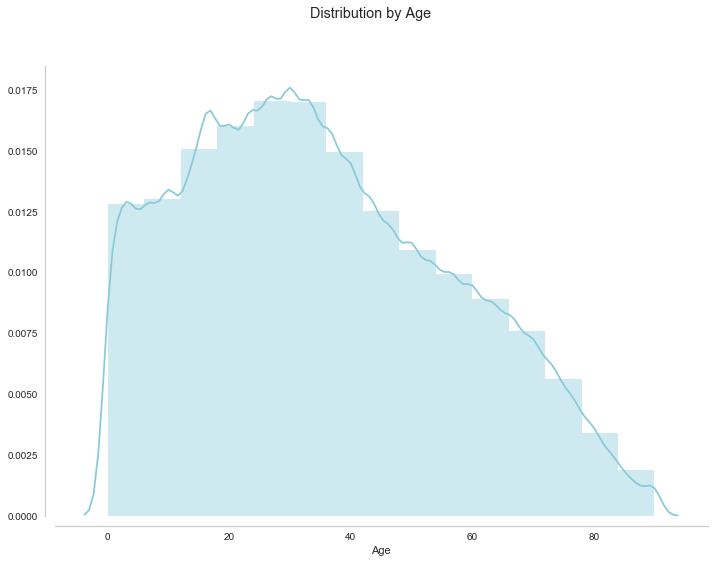

In [10]:
y = df.loc[:,'age']
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
age = sns.distplot(y, bins=15, color='c', ax=ax)
ax.set_xlabel('Age')
ax.grid(False)
fig.suptitle('Distribution by Age')
sns.despine(offset=10, trim=False)

Calculating population breakdown by Race.

 White:  1584581
 Black:  180475
 American Indian / Alaskan Native:  18859
 Asian / Pacific Islander:  43128
 Other NonWhite:  5139


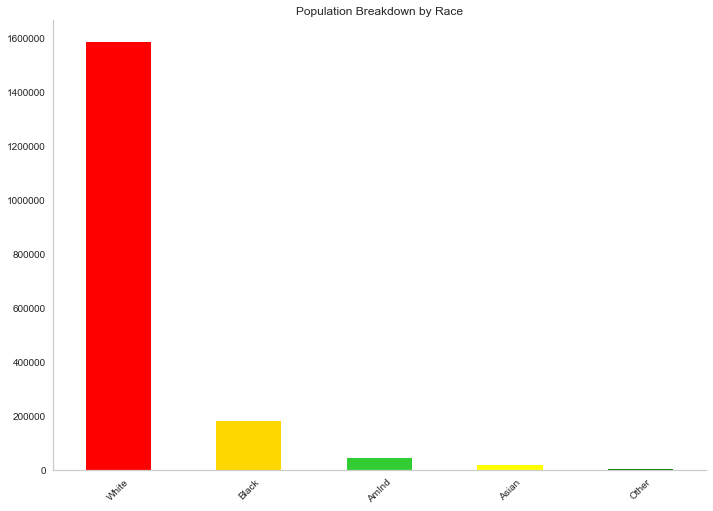

In [11]:
Race = df.race.value_counts()
print(color.BOLD, 'White:', color.END, Race[1.0])
print(color.BOLD, 'Black:', color.END, Race[2.0])
print(color.BOLD, 'American Indian / Alaskan Native:', color.END, Race[3.0])
print(color.BOLD, 'Asian / Pacific Islander:', color.END, Race[4.0])
print(color.BOLD, 'Other NonWhite:', color.END, Race[5.0])
my_colors = ["red", "gold", "limegreen", "yellow", "green"]
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
Race.plot(kind='bar', title='Population Breakdown by Race', color=my_colors, ax=ax)
ax.set_xticklabels(['White', 'Black', 'AmInd', 'Asian', 'Other'], rotation = 45)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Plotting distribution of death outcomes by Age.

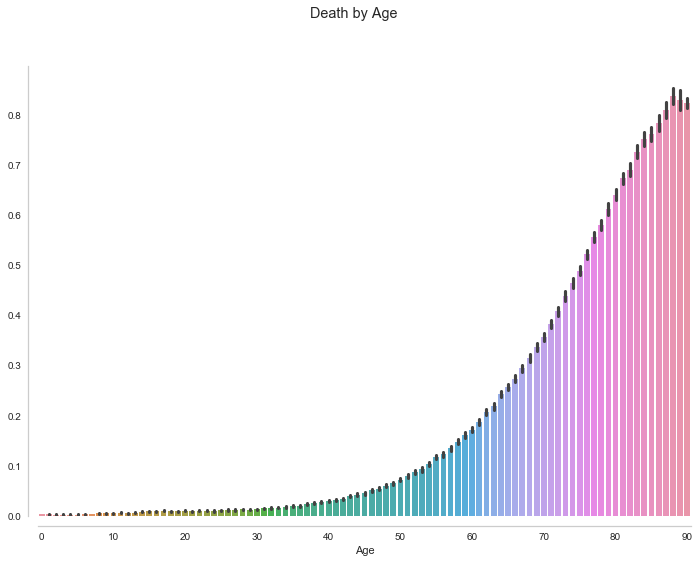

In [12]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
age1 = sns.barplot(x='age', y='inddea', data=df, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('')
ax.set_xticks(np.arange(0, 91, step=10))
ax.set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70', '80', '90'], rotation=45)
ax.grid(False)
fig.suptitle('Death by Age')
sns.despine(offset=10, trim=False)

From the plot above it is obvious that deaths outcomes occuring from birth up to 20 years of age are very sparse. hence, we will drop those records to focus on the main group of people which face higher probability of 11-year mortality.

In [13]:
df = df[df.age >= 20]

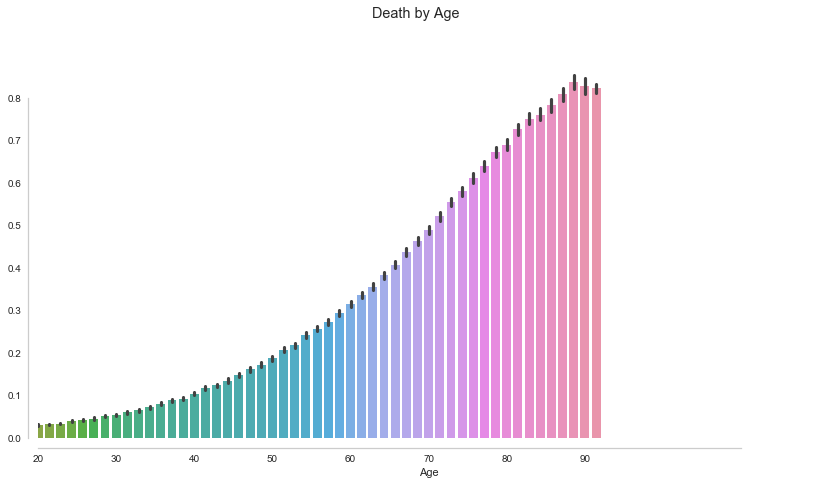

In [14]:
a4_dims = (14, 7)
fig, ax = plt.subplots(figsize=a4_dims)
age1 = sns.barplot(x='age', y='inddea', data=df, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('')
ax.set_xticks(np.arange(20, 90, step=7))
ax.set_xticklabels(['20', '30', '40', '50', '60', '70', '80', '90'], rotation=45)
ax.set_xlim(20, 90)
ax.grid(False)
fig.suptitle('Death by Age')
sns.despine(offset=10, trim=True)

Population breakdown by Target Class.

 Survived:  1674322
 Died:  160750
 Proportion:  10.42 : 1


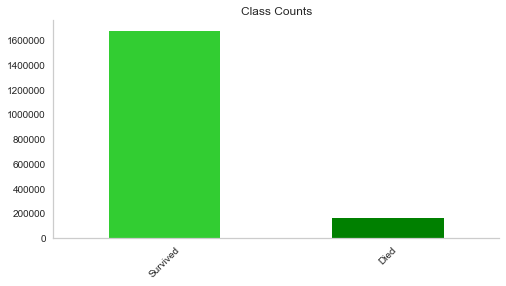

In [15]:
IndDea = dataset.inddea.value_counts()
print(color.BOLD, 'Survived:', color.END, IndDea[0])
print(color.BOLD, 'Died:', color.END, IndDea[1])
print(color.BOLD, 'Proportion:', color.END, round(IndDea[0] / IndDea[1], 2), ': 1')
my_colors = ["limegreen", "green"]
a4_dims = (8, 4)
fig, ax = plt.subplots(figsize=a4_dims)
IndDea.plot(kind='bar', title='Class Counts', color=my_colors, ax=ax)
ax.set_xticklabels(['Survived', 'Died'], rotation = 45)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

As we can see from the bar chart above, this data set has a class imbalance issue, which will have to be addressed in the modeling stage of this project.

Plotting data by Age, Gender and Outcome.

(10, 100)

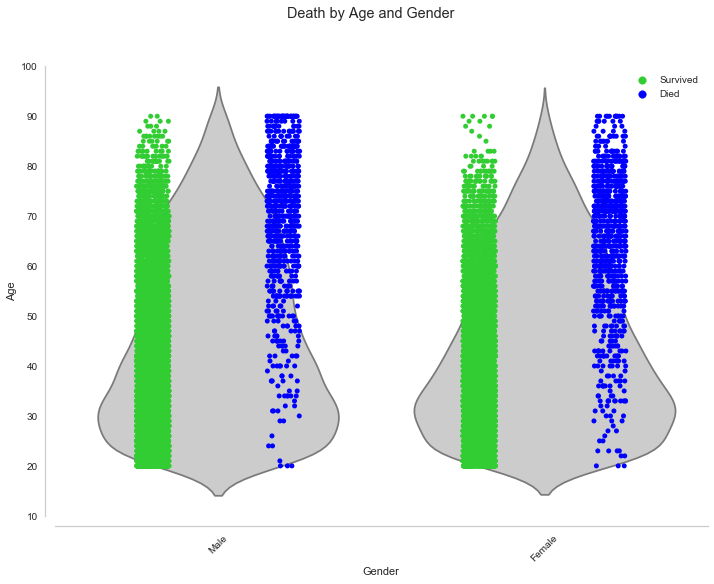

In [17]:
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['limegreen', 'blue', 'turquoise'])
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
inc_1 = sns.violinplot(x="sex", y="age", data=df.sample(15000), inner=None, color=".8")
inc_1 = sns.stripplot(x='sex', y='age', hue='inddea', data=df.sample(15000), jitter=1, dodge=True, ax=ax)
fig.suptitle('Death by Age and Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Age')
handles, labels = ax.get_legend_handles_labels()
labels2 = ('Survived', 'Died')
ax.legend(handles, labels2)
sns.despine(offset=10, trim=False)
ax.grid(False)
ax.set_xticklabels(['Male', 'Female'], rotation=45)
ax.set_ylim(10, 100)

Plotting data by Race and Age.

[Text(0,0,'White'),
 Text(0,0,'Black'),
 Text(0,0,'AmInd'),
 Text(0,0,'Asian'),
 Text(0,0,'Other')]

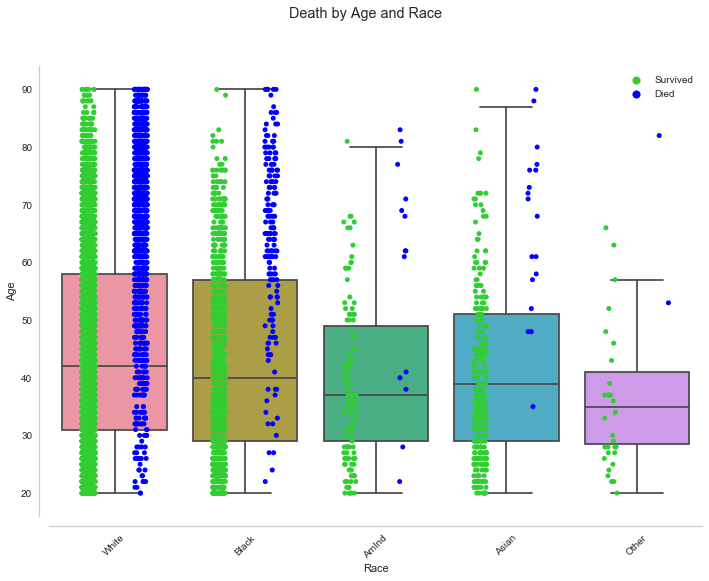

In [18]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
race1 = sns.boxplot(x="race", y="age", data=df.sample(15000), whis=np.inf)
race1 = sns.stripplot(x='race', y='age', hue='inddea', data=df.sample(15000), jitter=True, dodge=True, ax=ax)
fig.suptitle('Death by Age and Race')
ax.set_xlabel('Race')
ax.set_ylabel('Age')
handles, labels = ax.get_legend_handles_labels()
labels2 = ('Survived', 'Died')
ax.legend(handles, labels2)
sns.despine(offset=10, trim=False)
ax.grid(False)
ax.set_xticklabels(['White', 'Black', 'AmInd', 'Asian', 'Other'], rotation=45)

Plotting data by Urban vs. Rural.

[Text(0,0,'Urban'), Text(0,0,'Rural')]

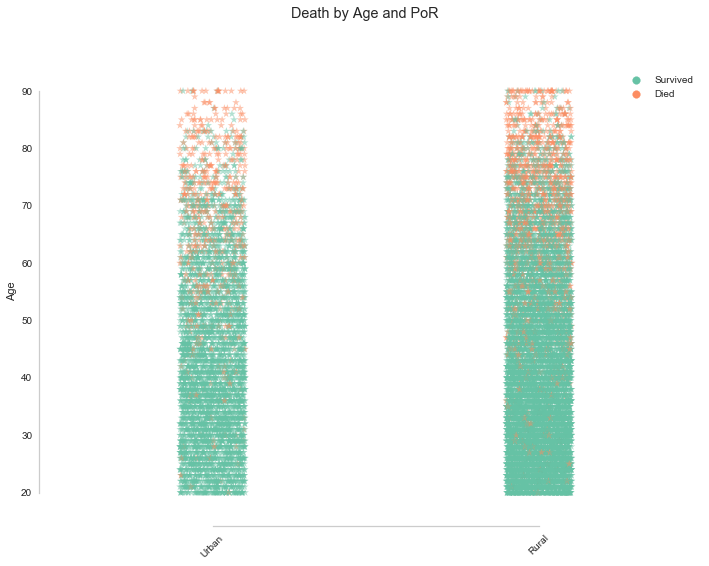

In [19]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
race3 =  sns.stripplot(x="urban", y="age", hue="inddea", data=df.sample(15000), palette="Set2", size=8, marker="*", jitter=True, edgecolor="gray", alpha=.5, ax=ax)
fig.suptitle('Death by Age and PoR')
ax.set_xlabel('')
ax.set_ylabel('Age')
handles, labels = ax.get_legend_handles_labels()
labels2 = ('Survived', 'Died')
ax.legend(handles, labels2)
sns.despine(offset=10, trim=True)
ax.grid(False)
race3.set_xticklabels(["Urban", "Rural"], rotation=45)

Death by Race and Gender.

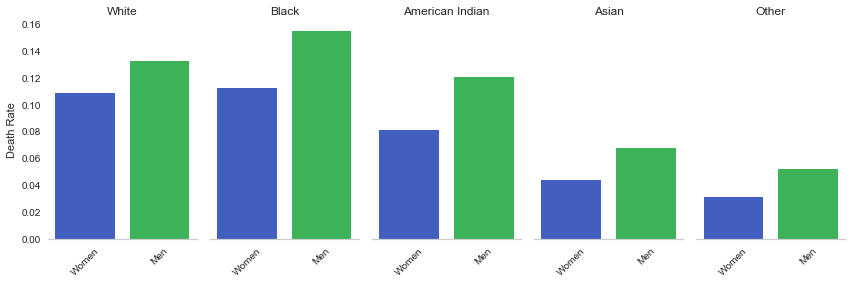

In [20]:
rs = sns.factorplot(x="sex", y="inddea", col="race", data=df, saturation=.5, kind="bar", palette='bright', ci=None, aspect=.6)
(rs.set_axis_labels("", "Death Rate")
 .set_xticklabels(["Women", "Men"], rotation=45)
 .despine(left=True))
title1 = ['White']
title2 = ['Black']
title3 = ['American Indian']
title4 = ['Asian']
title5 = ['Other']
for ax, title in zip(rs.axes, title1):
    ax[0].grid(False)
    ax[0].set_title(title)
for ax, title in zip(rs.axes, title2):
    ax[1].grid(False)
    ax[1].set_title(title)
for ax, title in zip(rs.axes, title3):
    ax[2].grid(False)
    ax[2].set_title(title)
for ax, title in zip(rs.axes, title4):
    ax[3].grid(False)
    ax[3].set_title(title)
for ax, title in zip(rs.axes, title5):
    ax[4].grid(False)
    ax[4].set_title(title)

## Feature Analysis and Selection.

Looking at the correlation coefficients between features and target, as well as between independent features to assess their importance in relation with the target, as well as to spot potential feature multicollinearity.

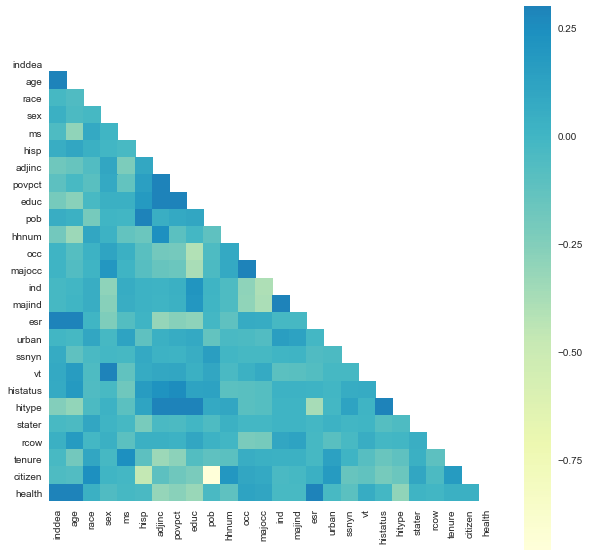

In [21]:
corr = df.loc[:, ['inddea', 'age', 'race', 'sex', 'ms', 'hisp', 'adjinc', 'povpct', 'educ', 'pob', 'hhnum', 'occ', 'majocc', 'ind', 'majind', 'esr', 'urban', 'ssnyn', 'vt', 'histatus', 'hitype', 'stater', 'rcow', 'tenure', 'citizen', 'health']].corr()
plt.figure(figsize=(10, 10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap='YlGnBu', center=0)
    ax.grid(False)

Let's put all coefficients into a list and sort them in ascending order to understand which features are the most important ones when it comes to predicting mortality.

In [22]:
cor_dict = corr['inddea'].to_dict()
del cor_dict['inddea']
print(color.BOLD, "List of the features decendingly by their correlation with IndDea:", color.END)
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: {1}".format(*ele))

 List of the features decendingly by their correlation with IndDea: 
age: 0.47279981680310834
esr: 0.30524133503802736
health: 0.2997589423179117
hitype: -0.24949086078973384
educ: -0.20634502921593692
hhnum: -0.1895519384848139
adjinc: -0.1807767483867445
povpct: -0.10864132294498163
vt: 0.07890443652287422
histatus: 0.07650457331185978
ssnyn: 0.06480591469027464
hisp: 0.05820344971302027
pob: 0.05422341145802978
ms: -0.05289944313706693
citizen: -0.05267157315445857
sex: 0.038598077462055604
rcow: 0.03752647773876065
tenure: -0.02902560462998232
stater: -0.02606307524597292
race: -0.023641640201919008
ind: -0.0183838374971783
majind: -0.01667241782608404
majocc: 0.014255597385512504
occ: 0.012111412998736465
urban: -0.002808195790374062


To confirm that Age does impact mortality outcome, we will plot a linear regression model against Age variable with a 68% confidence interval, which corresponds with the standard error of the estimate:

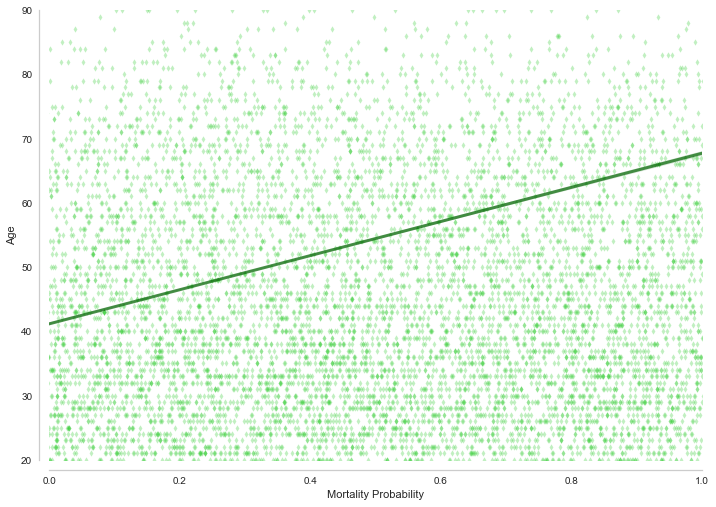

In [23]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
l = sns.regplot(x = 'inddea', y = 'age', data = df.sample(15000), ci=68, robust=True, x_jitter=1.0, marker="d", scatter_kws={"color":"limegreen", "edgecolor":"green", "alpha":0.3, "s":20}, line_kws={"color": "darkgreen", "alpha":0.7, "lw":3}, ax=ax)
l.set(xlim=(0, 1))
l.set(ylim=(20, 90))
sns.despine(offset=10, trim=True)
ax.set_xlabel('Mortality Probability')
ax.set_ylabel('Age')
ax.grid(False)

Employment Status feature was also among those with the highest coefficient, therefore, let's take a look at a linear regression model against Employment variable:

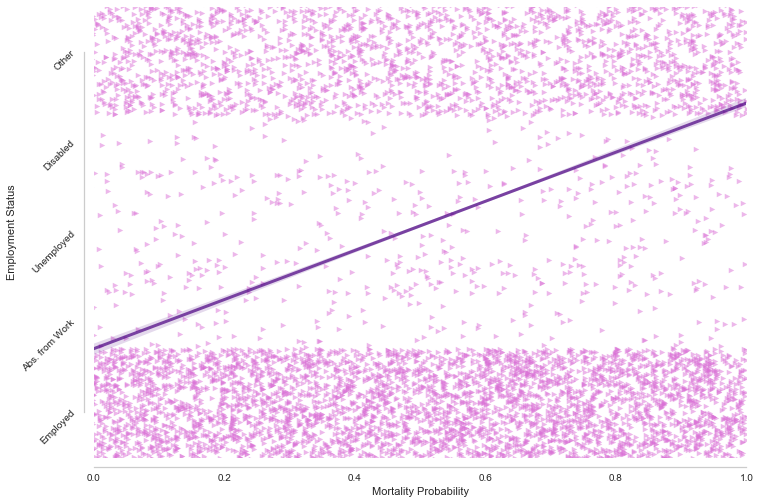

In [24]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
l = sns.regplot(x = 'inddea', y = 'esr', data = df.sample(15000), ci=68, robust=True, y_jitter=0.7, x_jitter=1.0, marker=">", scatter_kws={"color": "orchid", "edgecolor":"purple", "alpha":0.5, "s":30}, line_kws={"color": "indigo", "alpha":0.7, "lw":3}, ax=ax)
l.set(xlim=(0, 1))
l.set(ylim=(0.5, 5.5))
sns.despine(offset=10, trim=True)
ax.set_xlabel('Mortality Probability')
ax.set_ylabel('Employment Status')
ax.set_yticklabels(["Employed", "Abs. from Work", "Unemployed", "Disabled", "Other"], rotation=45)
ax.grid(False)

Plotting mortality outcome against Education, Income and Gender variables.

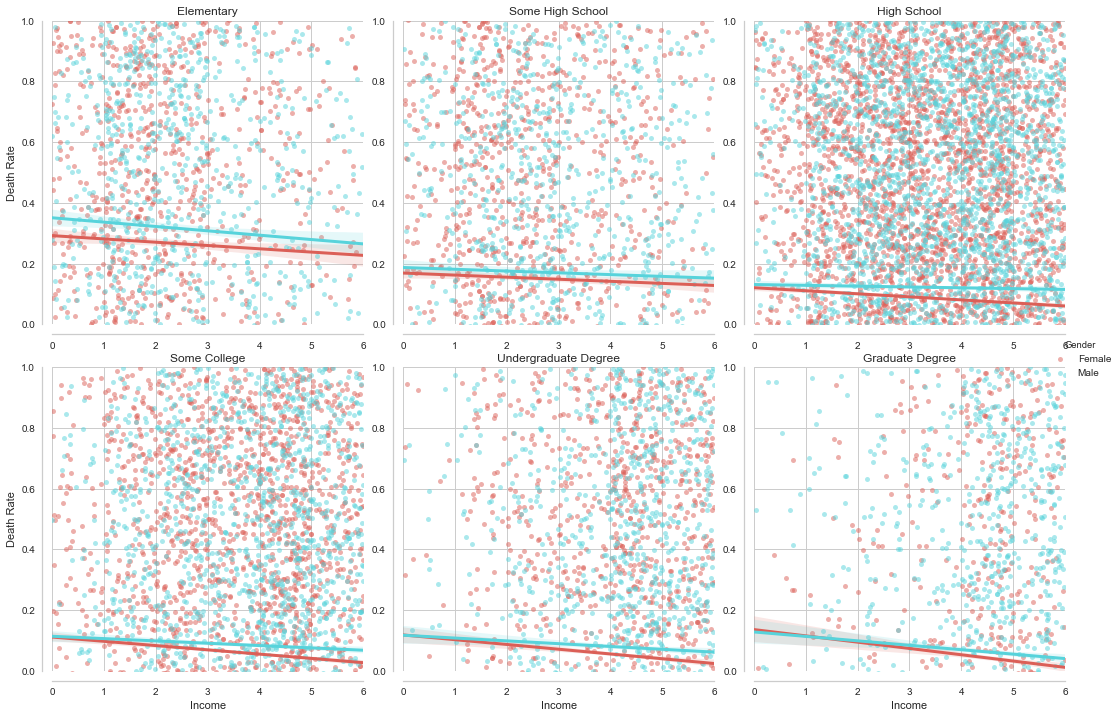

In [25]:
df1 = (df.loc[df['educ'].isin([2,5,8,9,12,13])])
g = sns.lmplot(x="povpct", y="inddea",ci=68, data=df1.sample(25000), col="educ", hue="sex", size=5, legend_out=True, palette="hls", col_wrap=3, scatter_kws={"s": 25, "edgecolor":"silver", "alpha":.5}, line_kws={"lw":3, "alpha":1.0}, x_jitter=1.0, y_jitter=1.0, sharex=False, sharey=False)
(g.set_axis_labels("Income", "Death Rate")
 .despine(left=True))
fig = g.fig
a0 = fig.axes[0]
a0.set_title("Elementary")
a1 = fig.axes[1]
a1.set_title("Some High School")
a2 = fig.axes[2]
a2.set_title("High School")
a3 = fig.axes[3]
a3.set_title("Some College")
a4 = fig.axes[4]
a4.set_title("Undergraduate Degree")
a5 = fig.axes[5]
a5.set_title("Graduate Degree")
g.set(xlim=(0, 6))
g.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
new_labels = ['Female', 'Male']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g._legend.set_title('Gender')

##### Since we are dealing with survival property of our population under investigation, it is appropriate to use Kaplan-Keier estimator, which is a non-parametric statistic used to estimate the survival function from lifetime data. In medical research, it is often used to measure the fraction of patients living for a certain amount of time after treatment, or, in our case, after a start of an 11-year follow-up period..

In [26]:
# Creating Duration array and Outcome array to fit the Kaplan-Meier model
D = df["follow"]
O = df["inddea"]

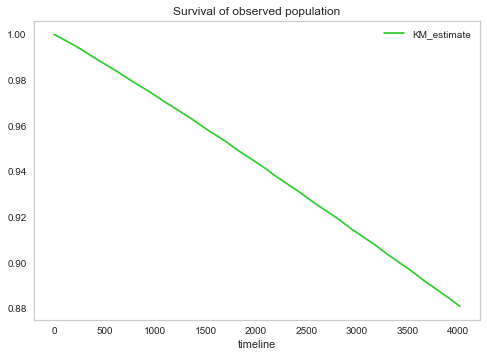

In [27]:
# Creating KMF model
kmf = KaplanMeierFitter()
kmf.fit(D, event_observed=O)
kmf.survival_function_.plot()
plt.title('Survival of observed population')
plt.grid(False)

To gain deeper insights into how mortality of a population changes when considering different variables within the same feature, we need to discriminate that feature of interest. For instance, in the plots below we will be looking at population mortality broken down by Place of Birth, Recorder Class of Worker, Health Insurance Type, etc.

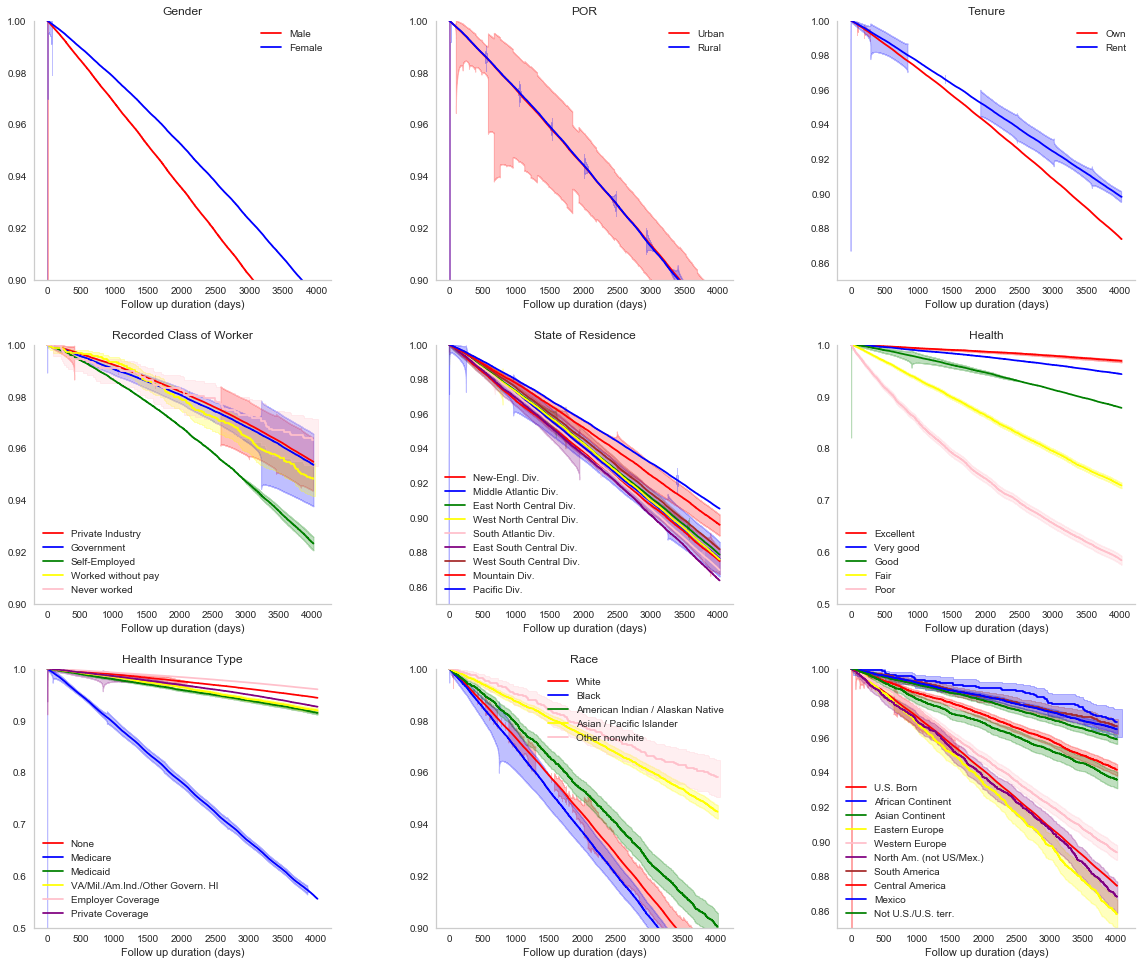

In [28]:
# Arranging all plots together to facilitate visual comparison
# Plotting survival probability by Gender
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red', 'blue', 'green', 'yellow', 'pink', 'purple', 'brown'])
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(331)
sex = (df["sex"] == 1)
kmf.fit(D[sex], event_observed=O[sex], label="Male")
kmf.plot(ax=ax, ci_force_lines=False)
kmf.fit(D[~sex], event_observed=O[~sex], label="Female")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.9, 1);
plt.title("Gender")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
# Plotting survival probability by Urban vs Rural POR
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(332)
POR = (df["urban"] == 1)
kmf.fit(D[POR], event_observed=O[POR], label="Urban")
kmf.plot(ax=ax, ci_force_lines=False)
kmf.fit(D[~POR], event_observed=O[~POR], label="Rural")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.9, 1);
plt.title("POR")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
# Plotting survival probability by Tenure
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(333)
ten = (df["tenure"] == 1)
kmf.fit(D[ten], event_observed=O[ten], label="Own")
kmf.plot(ax=ax, ci_force_lines=False)
kmf.fit(D[~ten], event_observed=O[~ten], label="Rent")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.85, 1);
plt.title("Tenure")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
# Plotting survival probability by RCOW
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(334)
rcow = (df["rcow"] == 1)
kmf.fit(D[rcow], event_observed=O[rcow], label="Private Industry")
kmf.plot(ax=ax, ci_force_lines=False)
rcow2 = (df["rcow"] == 2)
kmf.fit(D[rcow2], event_observed=O[rcow2], label="Government")
kmf.plot(ax=ax, ci_force_lines=False)
rcow3 = (df["rcow"] == 3)
kmf.fit(D[rcow3], event_observed=O[rcow3], label="Self-Employed")
kmf.plot(ax=ax, ci_force_lines=False)
rcow4 = (df["rcow"] == 4)
kmf.fit(D[rcow4], event_observed=O[rcow4], label="Worked without pay")
kmf.plot(ax=ax, ci_force_lines=False)
rcow5 = (df["rcow"] == 5)
kmf.fit(D[rcow5], event_observed=O[rcow5], label="Never worked")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.9, 1);
plt.title("Recorded Class of Worker")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
# Plotting survival probability by StateR
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(335)
state1 = (df["stater"] == 1)
kmf.fit(D[state1], event_observed=O[state1], label="New-Engl. Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state2 = (df["stater"] ==2)
kmf.fit(D[state2], event_observed=O[state2], label="Middle Atlantic Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state3 = (df["stater"] == 3)
kmf.fit(D[state3], event_observed=O[state3], label="East North Central Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state4 = (df["stater"] == 4)
kmf.fit(D[state4], event_observed=O[state4], label="West North Central Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state5 = (df["stater"] == 5)
kmf.fit(D[state5], event_observed=O[state5], label="South Atlantic Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state6 = (df["stater"] == 6)
kmf.fit(D[state6], event_observed=O[state6], label="East South Central Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state7 = (df["stater"] == 7)
kmf.fit(D[state7], event_observed=O[state7], label="West South Central Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state8 = (df["stater"] == 8)
kmf.fit(D[state8], event_observed=O[state8], label="Mountain Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state9 = (df["stater"] == 9)
kmf.fit(D[state9], event_observed=O[state9], label="Pacific Div.")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.85, 1);
plt.title("State of Residence")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
# Plotting survival probability by Health
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(336)
health1 = (df["health"]==1)
kmf.fit(D[health1], event_observed=O[health1], label="Excellent")
kmf.plot(ax=ax, ci_force_lines=False)
health2 = (df["health"]==2)
kmf.fit(D[health2], event_observed=O[health2], label="Very good")
kmf.plot(ax=ax, ci_force_lines=False)
health3 = (df["health"]==3)
kmf.fit(D[health3], event_observed=O[health3], label="Good")
kmf.plot(ax=ax, ci_force_lines=False)
health4 = (df["health"]==4)
kmf.fit(D[health4], event_observed=O[health4], label="Fair")
kmf.plot(ax=ax, ci_force_lines=False)
health5 = (df["health"]==5)
kmf.fit(D[health5], event_observed=O[health5], label="Poor")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.5, 1);
plt.title("Health")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
# Plotting survival probability by Health Insurance Type
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(337)
hitype = (df["hitype"]==0)
kmf.fit(D[hitype], event_observed=O[hitype], label="None")
kmf.plot(ax=ax, ci_force_lines=False)
hitype1 = (df["hitype"]==1)
kmf.fit(D[hitype1], event_observed=O[hitype1], label="Medicare")
kmf.plot(ax=ax, ci_force_lines=False)
hitype2 = (df["hitype"]==2)
kmf.fit(D[hitype2], event_observed=O[hitype2], label="Medicaid")
kmf.plot(ax=ax, ci_force_lines=False)
hitype3 = (df["hitype"]==3)
kmf.fit(D[hitype3], event_observed=O[hitype3], label="VA/Mil./Am.Ind./Other Govern. HI")
kmf.plot(ax=ax, ci_force_lines=False)
hitype4 = (df["hitype"]==4)
kmf.fit(D[hitype4], event_observed=O[hitype4], label="Employer Coverage")
kmf.plot(ax=ax, ci_force_lines=False)
hitype5 = (df["hitype"]==5)
kmf.fit(D[hitype5], event_observed=O[hitype5], label="Private Coverage")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.5, 1);
plt.title("Health Insurance Type")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
# Plotting survival probability by Race
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(338)
race1 = (df["race"]==1)
kmf.fit(D[race1], event_observed=O[race1], label="White")
kmf.plot(ax=ax, ci_force_lines=False)
race2 = (df["race"]==2)
kmf.fit(D[race2], event_observed=O[race2], label="Black")
kmf.plot(ax=ax, ci_force_lines=False)
race3 = (df["race"]==3)
kmf.fit(D[race3], event_observed=O[race3], label="American Indian / Alaskan Native")
kmf.plot(ax=ax, ci_force_lines=False)
race4 = (df["race"]==4)
kmf.fit(D[race4], event_observed=O[race4], label="Asian / Pacific Islander")
kmf.plot(ax=ax, ci_force_lines=False)
race5 = (df["race"]==5)
kmf.fit(D[race5], event_observed=O[race5], label="Other nonwhite")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.9, 1)
plt.title("Race")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
# Plotting survival probability by POB
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(339)
us=[900]
pob1 = (df["pob"].isin(us))
kmf.fit(D[pob1], event_observed=O[pob1], label="U.S. Born")
kmf.plot(ax=ax, ci_force_lines=False)
pob2 = (df["pob"]==101)
kmf.fit(D[pob2], event_observed=O[pob2], label="African Continent")
kmf.plot(ax=ax, ci_force_lines=False)
pob3 = (df["pob"]==102)
kmf.fit(D[pob3], event_observed=O[pob3], label="Asian Continent")
kmf.plot(ax=ax, ci_force_lines=False)
pob4 = (df["pob"]==103)
kmf.fit(D[pob4], event_observed=O[pob4], label="Eastern Europe")
kmf.plot(ax=ax, ci_force_lines=False)
pob5 = (df["pob"]==104)
kmf.fit(D[pob5], event_observed=O[pob5], label="Western Europe")
kmf.plot(ax=ax, ci_force_lines=False)
pob6 = (df["pob"]==105)
kmf.fit(D[pob6], event_observed=O[pob6], label="North Am. (not US/Mex.)")
kmf.plot(ax=ax, ci_force_lines=False)
pob7 = (df["pob"]==106)
kmf.fit(D[pob7], event_observed=O[pob7], label="South America")
kmf.plot(ax=ax, ci_force_lines=False)
pob8 = (df["pob"]==107)
kmf.fit(D[pob8], event_observed=O[pob8], label="Central America")
kmf.plot(ax=ax, ci_force_lines=False)
pob9 = (df["pob"]==108)
kmf.fit(D[pob9], event_observed=O[pob9], label="Mexico")
kmf.plot(ax=ax, ci_force_lines=False)
pob10 = (df["pob"]==110)
kmf.fit(D[pob10], event_observed=O[pob10], label="Not U.S./U.S. terr.")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.85, 1)
plt.title("Place of Birth")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

In [29]:
# Doing the same in plotly
# Plotting survival probability by Health Insurance Type
fig = plt.gcf()
#fig.set_size_inches(18,15)
ax = plt.subplot(331)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
hitype = (dataset["hitype"]==0)
kmf.fit(D[hitype], event_observed=O[hitype], label="None")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
hitype1 = (dataset["hitype"]==1)
kmf.fit(D[hitype1], event_observed=O[hitype1], label="Medicare")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
hitype2 = (dataset["hitype"]==2)
kmf.fit(D[hitype2], event_observed=O[hitype2], label="Medicaid")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
hitype3 = (dataset["hitype"]==3)
kmf.fit(D[hitype3], event_observed=O[hitype3], label="VA/Mil./Am.Ind./Other Govern. HI")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
hitype4 = (dataset["hitype"]==4)
kmf.fit(D[hitype4], event_observed=O[hitype4], label="Employer Coverage")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
hitype5 = (dataset["hitype"]==5)
kmf.fit(D[hitype5], event_observed=O[hitype5], label="Private Coverage")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
plt.ylim(0.5, 1);
ax.grid(False)
#plt.title("Health Insurance Type")
plt.xlabel("Follow up duration (days)")

tls.set_credentials_file(username='yg7891', api_key='cjs1S61VN1STTLYXnhz7')
b = plt.gcf()

def pyplot(b, ci=False, legend=True, filename='HealthInsurance_Interactive'):
    # Convert mpl fig obj to plotly fig obj, resize to plotly's default
    py_fig = tls.mpl_to_plotly(b, resize=True)
   
    if legend == True:
        # Add legend, place it at the top right corner of the plot
        py_fig['layout'].update(
            showlegend=True,
            title='Health Insurance',
            titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='black'),
            width=900,
            height=600,
            legend=layout.Legend(
                x=1.01,
                y=1
            )
        )
        
    # Send updated figure object to Plotly, show result in notebook
    return py.iplot(py_fig, filename=filename)
                   
pyplot(b)

The draw time for this plot will be slow for clients without much RAM.


After having performed some exploratory analysis, we can start preparing for getting our data ready for modeling. For that, we will need to drop some features from the data, because they have a high rate of missing data. With that being said, we need to keep in mind that our dataset is class imbalanced, and therefore, dropping records might increase the imbalance gap.

In [30]:
# Dropping some variables from the dataset
df = df.drop(['record', 'race', 'hisp', 'adjinc', 'hhid', 'hhnum', 'reltrf', 'occ', 'majocc', 'ind', 'majind', 'smsast', 'cause113', 'follow', 'dayod', 'hosp', 'hospd', 'povpct', 'stater',
       'rcow', 'tenure', 'citizen', 'health'], axis=1)
df.columns

Index(['age', 'sex', 'ms', 'educ', 'pob', 'esr', 'urban', 'inddea', 'ssnyn',
       'vt', 'histatus', 'hitype'],
      dtype='object')

In [31]:
# Creating list of features for future use
features = ['age', 'sex', 'ms', 'educ', 'pob', 'esr', 'urban', 'ssnyn',
       'vt', 'histatus', 'hitype']

In [32]:
# Dropping rows with missing values
df.dropna(axis=0, how='any', inplace=True)

In [33]:
df.count()

age         934809
sex         934809
ms          934809
educ        934809
pob         934809
esr         934809
urban       934809
inddea      934809
ssnyn       934809
vt          934809
histatus    934809
hitype      934809
dtype: int64

In [34]:
# Casting data type as int instead of float
df.ms = df.ms.astype(int)
df.educ = df.educ.astype(int)
df.esr = df.esr.astype(int)
df.urban = df.urban.astype(int)
df.vt = df.vt.astype(int)
df.histatus = df.histatus.astype(int)
df.hitype = df.hitype.astype(int)

In [35]:
# Splitting dataset into a matrix of features and array of labels
X = df.drop(['inddea'], axis=1)
y = df.loc[:, 'inddea']

We will be using YellowBrick Feature Importance Visualizers to compare feature importance with Ridge, Lasso and ElasticNet feature selection models side by side.

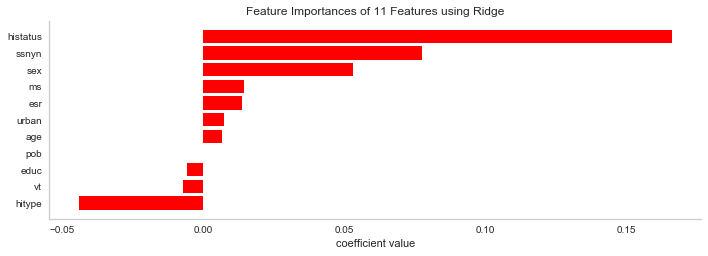

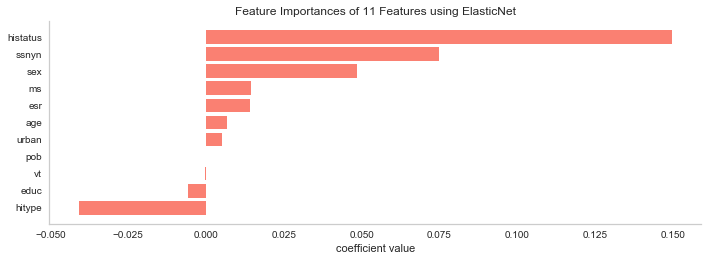

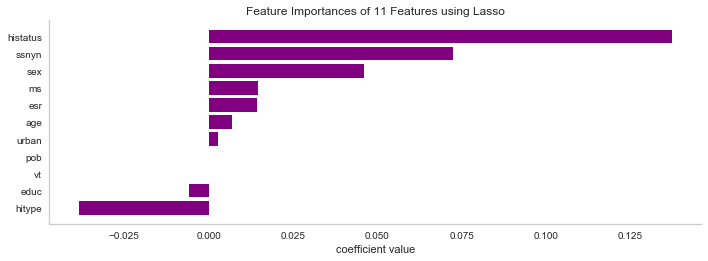

In [36]:
# Ridge
# Create a new figure
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red'])
fig = plt.gcf()
fig.set_size_inches(10,10)
ax = plt.subplot(311)
labels = features
viz = FeatureImportances(Ridge(alpha=0.5), ax=ax, labels=labels, relative=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

# Fit and display
viz.fit(X, y)
viz.poof()

# ElasticNet
# Create a new figure
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['salmon'])
fig = plt.gcf()
fig.set_size_inches(10,10)
ax = plt.subplot(312)
labels = features
viz = FeatureImportances(ElasticNet(alpha=0.001), ax=ax, labels=labels, relative=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

# Fit and display
viz.fit(X, y)
viz.poof()

# Lasso
# Create a new figure
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['purple'])
fig = plt.gcf()
fig.set_size_inches(10,10)
ax = plt.subplot(313)
labels = features
viz = FeatureImportances(Lasso(alpha=0.001), ax=ax, labels=labels, relative=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

# Fit and display
viz.fit(X, y)
viz.poof()

In [37]:
df.head()

,age,sex,ms,educ,pob,esr,urban,inddea,ssnyn,vt,histatus,hitype
577765,61,1,1,2,900,5,1,0,1,1,0,0
577766,63,0,1,5,900,5,1,0,1,0,0,0
577767,67,0,2,2,900,5,1,0,1,0,1,1
577768,55,1,1,5,900,1,1,0,1,1,1,4
577769,52,0,1,8,900,1,1,0,1,0,1,4


In [38]:
# Encoding some hierarchical features for modeling purposes.
X = pd.get_dummies(data=X, columns=['ms', 'educ', 'pob', 'esr', 'hitype'])

In [39]:
X.head()
cols = (X.columns)
print(cols)
X.shape

Index(['age', 'sex', 'urban', 'ssnyn', 'vt', 'histatus', 'ms_1', 'ms_2',
       'ms_3', 'ms_4', 'ms_5', 'educ_1', 'educ_2', 'educ_5', 'educ_8',
       'educ_9', 'educ_12', 'educ_13', 'pob_0', 'pob_101', 'pob_102',
       'pob_103', 'pob_104', 'pob_105', 'pob_106', 'pob_107', 'pob_108',
       'pob_110', 'pob_900', 'esr_1', 'esr_2', 'esr_3', 'esr_4', 'esr_5',
       'hitype_0', 'hitype_1', 'hitype_2', 'hitype_3', 'hitype_4', 'hitype_5'],
      dtype='object')


(934809, 40)

In [40]:
# Univariate feature selection
test = SelectKBest(chi2, k=10)
fit = test.fit(X, y)
np.set_printoptions(precision=3)
print(fit.scores_)

[1.384e+06 6.445e+02 1.155e+01 3.725e+02 7.667e+03 7.950e+02 1.353e+03
 6.512e+04 1.514e+02 1.208e+02 7.173e+03 8.953e+02 3.005e+04 3.424e+03
 6.797e+02 3.999e+03 3.391e+03 1.571e+03 3.650e+02 1.083e+02 1.012e+03
 3.032e+01 4.192e+00 1.957e+01 4.359e+02 5.423e+02 1.621e+03 2.039e+02
 4.814e+02 3.126e+04 5.452e+02 1.491e+03 1.315e+04 5.643e+04 4.758e+03
 1.673e+05 3.281e+02 3.789e+01 3.024e+04 1.202e+03]


In [41]:
# Recursive Feature Elimination (RFE)
model = LogisticRegression()
rfe = RFE(model, 38)
fit = rfe.fit(X, y)
print("Num Features: ", fit.n_features_) 
print("Selected Features: ", fit.support_) 
print("Feature Ranking: ", fit.ranking_)

Num Features:  38
Selected Features:  [ True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Feature Ranking:  [1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


In [42]:
# Principle Component Analysis (PCA)
pca = PCA(n_components=11)
fit = pca.fit(X)
print("Explained Variance: ", fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance:  [9.887e-01 1.680e-03 1.111e-03 1.014e-03 9.242e-04 7.753e-04 7.208e-04
 6.286e-04 5.656e-04 4.209e-04 3.985e-04]
[[ 9.996e-01 -1.067e-03 -7.976e-04 -3.436e-03  4.037e-03  3.748e-03
   2.114e-03  6.522e-03 -4.286e-05 -3.070e-04 -8.286e-03  2.180e-04
   4.702e-03  1.203e-03 -1.141e-03 -3.495e-03 -1.490e-03  2.831e-06
  -1.013e-04 -3.905e-05 -2.894e-04  1.220e-04  1.739e-04  7.749e-05
  -8.846e-05 -1.273e-04 -6.153e-04 -4.859e-05  9.360e-04 -1.145e-02
  -3.083e-04 -1.243e-03  8.394e-04  1.216e-02 -3.746e-03  1.555e-02
  -1.063e-03 -1.305e-04 -1.013e-02 -4.727e-04]
 [-1.336e-02 -2.192e-01  5.117e-02 -8.822e-02 -1.372e-01 -2.545e-01
  -3.500e-01  9.797e-02  3.386e-02  2.042e-02  1.978e-01  6.545e-03
   8.006e-02  7.155e-02 -2.429e-02 -9.791e-03 -6.682e-02 -5.724e-02
   1.432e-02  2.488e-04  4.353e-03  1.080e-03  5.191e-04  2.039e-04
   2.313e-03  1.120e-02  2.435e-02  6.112e-03 -6.469e-02 -4.206e-01
   5.194e-03  3.865e-02  2.087e-02  3.559e-01  2.544e-01  1.485e-01
   

### Predictive Modeling

#### When choosing a predictive model to use with our data, we have to keep in mind linear nature of the relationship between features and a target, as well as class imbalance issue. Logistic Regression model can be a good start because it provides ability to balance classes with class_weight='balanced' parameter.

[[338931  73682]
 [  9921  44870]]


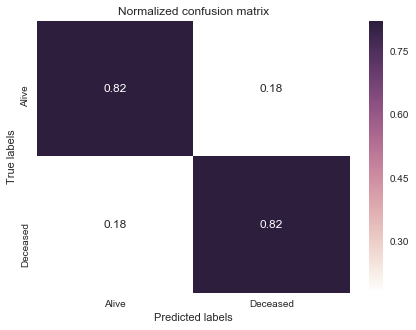

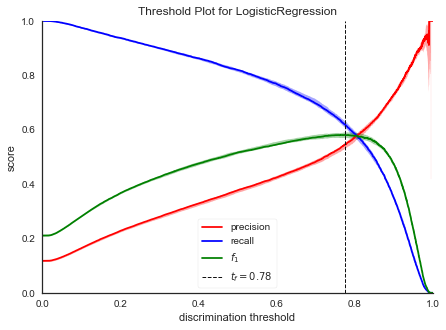

  Train Time: 8.024s 
 Validation scores are as follows:
 
 Recall Score:   0.8192162472993958
 Precision Score:   0.9019937845723365
 Accuracy Score:   0.820338701055106
 F1 Score:   0.8459706588201039


In [66]:
# Logistic Regression Model
estimator_lr = LogisticRegression(C=1, class_weight='balanced')
t0 = time() # Start the clock! 
scores_lr = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
n_splits=2
fold = KFold(n_splits=n_splits, shuffle=True)
    
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    estimator_lr.fit(X_train, y_train)
        
    expected  = y_test
    predicted = estimator_lr.predict(X_test)
        
    # Append our scores to the tracker
    scores_lr['precision'].append(metrics.precision_score(expected, predicted, average='weighted'))
    scores_lr['recall'].append(metrics.recall_score(expected, predicted))
    scores_lr['accuracy'].append(metrics.accuracy_score(expected, predicted))
    scores_lr['f1'].append(metrics.f1_score(expected, predicted, average='weighted'))
    
train_time_lr = time() - t0

cm = confusion_matrix(y_test, predicted)
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); 
ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)
    
# Instantiate the classification model and visualizer
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red', 'blue', 'green'])
figsize=(7, 5)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(estimator_lr, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data
    
# Report
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_lr, color.END)
print(color.BOLD, "Validation scores are as follows:\n", color.END)
print(color.BOLD, 'Recall Score: ', color.END, sum(scores_lr['recall'])/n_splits) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, sum(scores_lr['precision'])/n_splits)
print(color.BOLD, 'Accuracy Score: ', color.END, sum(scores_lr['accuracy'])/n_splits)
print(color.BOLD, 'F1 Score: ', color.END, sum(scores_lr['f1'])/n_splits)

lr_rec = sum(scores_lr['recall'])/n_splits
lr_pr = sum(scores_lr['precision'])/n_splits
lr_acc = sum(scores_lr['accuracy'])/n_splits
lr_f1 = sum(scores_lr['f1'])/n_splits

[[338615  74089]
 [  9951  44749]]


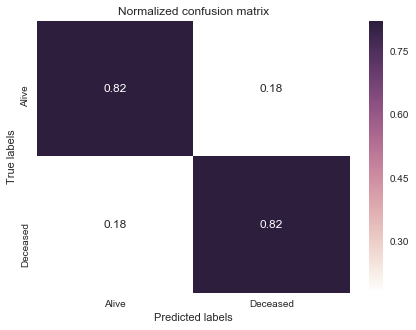

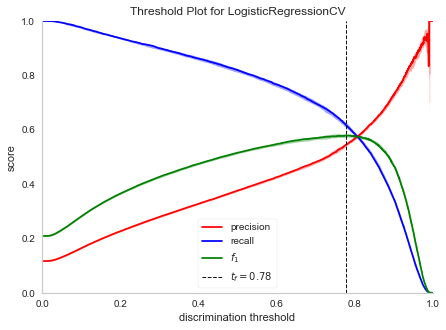

  Train Time: 78.763s 
 Validation scores are as follows:
 
 Recall Score:   0.8189962019175594
 Precision Score:   0.9019867293880086
 Accuracy Score:   0.8204606499699107
 F1 Score:   0.8460589943501253


In [44]:
# Logistic Regression Cross-Validation Model
estimator = LogisticRegressionCV(class_weight='balanced')
t0 = time() # Start the clock! 
scores_lrcv = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
n_splits=2
fold = KFold(n_splits=n_splits, shuffle=True)
    
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    estimator.fit(X_train, y_train)
        
    expected  = y_test
    predicted = estimator.predict(X_test)
        
    # Append our scores to the tracker
    scores_lrcv['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
    scores_lrcv['recall'].append(metrics.recall_score(expected, predicted))
    scores_lrcv['accuracy'].append(metrics.accuracy_score(expected, predicted))
    scores_lrcv['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))
    
train_time_lrcv = time() - t0

cm = confusion_matrix(y_test, predicted)
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); 
ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)
    
# Instantiate the classification model and visualizer
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red', 'blue', 'green'])
figsize=(7, 5)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(estimator, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data
    
# Report
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_lrcv, color.END)
print(color.BOLD, "Validation scores are as follows:\n", color.END)
print(color.BOLD, 'Recall Score: ', color.END, sum(scores_lrcv['recall'])/n_splits) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, sum(scores_lrcv['precision'])/n_splits)
print(color.BOLD, 'Accuracy Score: ', color.END, sum(scores_lrcv['accuracy'])/n_splits)
print(color.BOLD, 'F1 Score: ', color.END, sum(scores_lrcv['f1'])/n_splits)

lrcv_rec = sum(scores_lrcv['recall'])/n_splits
lrcv_pr = sum(scores_lrcv['precision'])/n_splits
lrcv_acc = sum(scores_lrcv['accuracy'])/n_splits
lrcv_f1 = sum(scores_lrcv['f1'])/n_splits

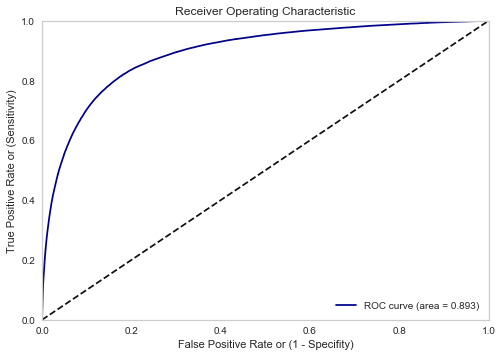

In [45]:
# Plotting ROC curve for logistic Regression model
y_pred_proba = estimator.predict_proba(X_test)
y_pred_proba[:5]
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, color='darkblue')
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(False)
plot_roc_curve(y_test, y_pred_proba)

#### Let's try Classifiers as well!

[[356711  56080]
 [ 14695  39918]]


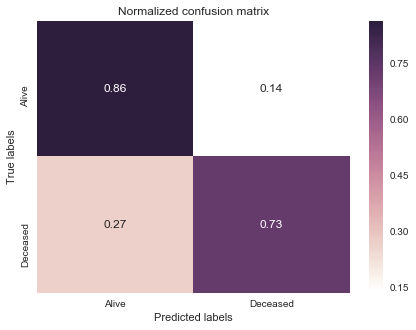

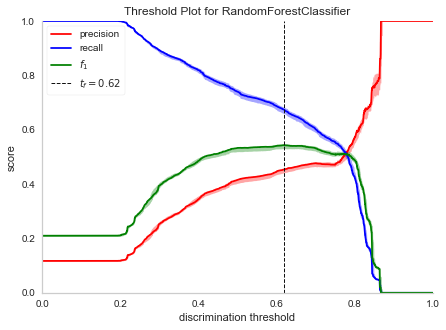

  Train Time: 9.645s 
 Validation scores are as follows:
 
 Recall Score:   0.7376313696347214
 Precision Score:   0.8970642453633562
 Accuracy Score:   0.8468136290567405
 F1 Score:   0.8641759412648462


In [46]:
# Random Forest Classifier Model
n_estimator = 25
estimator = RandomForestClassifier(max_depth=3, n_estimators=n_estimator, random_state=12, class_weight='balanced')
t0 = time() # Start the clock! 
scores_rf = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
n_splits=2
fold = KFold(n_splits=n_splits, shuffle=True)
    
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    estimator.fit(X_train, y_train)
        
    expected  = y_test
    predicted = estimator.predict(X_test)
        
    # Append our scores to the tracker
    scores_rf['precision'].append(metrics.precision_score(expected, predicted, average='weighted'))
    scores_rf['recall'].append(metrics.recall_score(expected, predicted))
    scores_rf['accuracy'].append(metrics.accuracy_score(expected, predicted))
    scores_rf['f1'].append(metrics.f1_score(expected, predicted, average='weighted'))
    
train_time_rf = time() - t0

cm = confusion_matrix(expected, predicted)
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); 
ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)
    
# Instantiate the classification model and visualizer
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red', 'blue', 'green'])
figsize=(7, 5)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(estimator, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data
    
# Report
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_rf, color.END)
print(color.BOLD, "Validation scores are as follows:\n", color.END)
print(color.BOLD, 'Recall Score: ', color.END, sum(scores_rf['recall'])/n_splits) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, sum(scores_rf['precision'])/n_splits)
print(color.BOLD, 'Accuracy Score: ', color.END, sum(scores_rf['accuracy'])/n_splits)
print(color.BOLD, 'F1 Score: ', color.END, sum(scores_rf['f1'])/n_splits)

rf_rec = sum(scores_rf['recall'])/n_splits
rf_pr = sum(scores_rf['precision'])/n_splits
rf_acc = sum(scores_rf['accuracy'])/n_splits
rf_f1 = sum(scores_rf['f1'])/n_splits

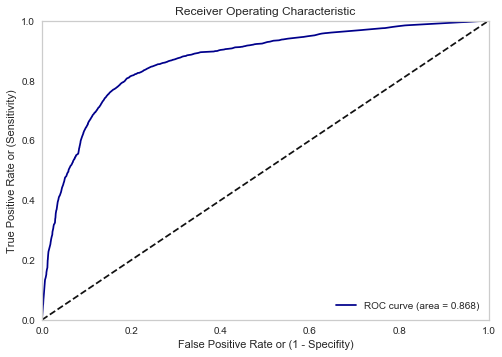

In [47]:
# Plotting ROC curve for random forest classifier model
y_pred_proba_rf = estimator.predict_proba(X_test)
y_pred_proba_rf[:5]
def plot_roc_curve(y_test, y_pred_proba_rf):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, color='darkblue')
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(False)
plot_roc_curve(y_test, y_pred_proba_rf)

[[342788  69873]
 [ 10549  44194]]


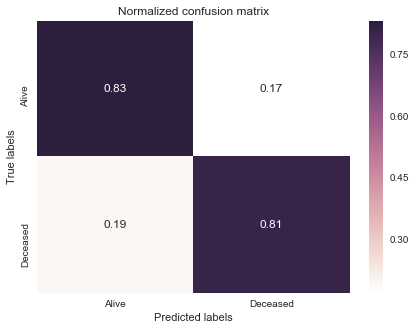

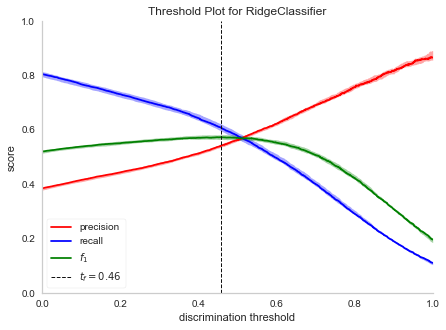

  Train Time: 2.697s 
 Validation scores are as follows:
 
 Recall Score:   0.805446593873661
 Precision Score:   0.9018011434377688
 Accuracy Score:   0.8285874433724492
 F1 Score:   0.8519707594816959


In [48]:
# Ridge Classifier Model
estimator = RidgeClassifier(random_state=12, class_weight='balanced')
t0 = time() # Start the clock! 
scores_rc = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
n_splits=2
fold = KFold(n_splits=n_splits, shuffle=True)
    
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    estimator.fit(X_train, y_train)
        
    expected  = y_test
    predicted = estimator.predict(X_test)
        
    # Append our scores to the tracker
    scores_rc['precision'].append(metrics.precision_score(expected, predicted, average='weighted'))
    scores_rc['recall'].append(metrics.recall_score(expected, predicted))
    scores_rc['accuracy'].append(metrics.accuracy_score(expected, predicted))
    scores_rc['f1'].append(metrics.f1_score(expected, predicted, average='weighted'))
    
train_time_rc = time() - t0

cm = confusion_matrix(expected, predicted)
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); 
ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)
    
# Instantiate the classification model and visualizer
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red', 'blue', 'green'])
figsize=(7, 5)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(estimator, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data
    
# Report
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_rc, color.END)
print(color.BOLD, "Validation scores are as follows:\n", color.END)
print(color.BOLD, 'Recall Score: ', color.END, sum(scores_rc['recall'])/n_splits) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, sum(scores_rc['precision'])/n_splits)
print(color.BOLD, 'Accuracy Score: ', color.END, sum(scores_rc['accuracy'])/n_splits)
print(color.BOLD, 'F1 Score: ', color.END, sum(scores_rc['f1'])/n_splits)

rc_rec = sum(scores_rc['recall'])/n_splits
rc_pr = sum(scores_rc['precision'])/n_splits
rc_acc = sum(scores_rc['accuracy'])/n_splits
rc_f1 = sum(scores_rc['f1'])/n_splits

[[330352  82021]
 [ 14321  40710]]


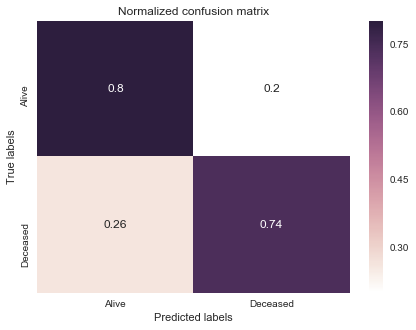

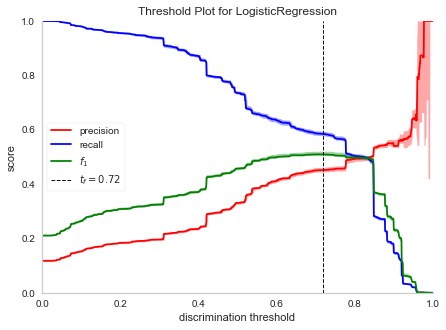

  Train Time: 21.586s 
 Validation scores are as follows:
 
 Recall Score:   0.7393881263382797
 Precision Score:   0.8851255342188435
 Accuracy Score:   0.7941932519747639
 F1 Score:   0.824318045360964


In [49]:
# Unsupervised transformation based on totally random trees
n_estimator = 10
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator, random_state=0)
rt_lm = LogisticRegression(class_weight='balanced')
estimator = make_pipeline(rt, rt_lm)
t0 = time()
scores_rt = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
n_splits=2
fold = KFold(n_splits=n_splits, shuffle=True)
    
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    estimator.fit(X_train, y_train)
        
    expected  = y_test
    predicted = estimator.predict(X_test)
        
    # Append our scores to the tracker
    scores_rt['precision'].append(metrics.precision_score(expected, predicted, average='weighted'))
    scores_rt['recall'].append(metrics.recall_score(expected, predicted))
    scores_rt['accuracy'].append(metrics.accuracy_score(expected, predicted))
    scores_rt['f1'].append(metrics.f1_score(expected, predicted, average='weighted'))
    
train_time_rt = time() - t0

cm = confusion_matrix(expected, predicted)
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); 
ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)
    
# Instantiate the classification model and visualizer
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red', 'blue', 'green'])
figsize=(7, 5)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(estimator, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data
    
# Report
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_rt, color.END)
print(color.BOLD, "Validation scores are as follows:\n", color.END)
print(color.BOLD, 'Recall Score: ', color.END, sum(scores_rt['recall'])/n_splits) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, sum(scores_rt['precision'])/n_splits)
print(color.BOLD, 'Accuracy Score: ', color.END, sum(scores_rt['accuracy'])/n_splits)
print(color.BOLD, 'F1 Score: ', color.END, sum(scores_rt['f1'])/n_splits)

rt_rec = sum(scores_rt['recall'])/n_splits
rt_pr = sum(scores_rt['precision'])/n_splits
rt_acc = sum(scores_rt['accuracy'])/n_splits
rt_f1 = sum(scores_rt['f1'])/n_splits

#### Besides class balancing whithin the model itlsef, there is a way to deal with class imbalance issue by performing over - and/or under- sampling with imbalanced-learn library. In this exrcise are going to try Synthetic Minority Over-sampling Technique combinead with Tomek links and Edited Nearest Neighbours algorithms respectively.

Original dataset shape Counter({0: 660203, 1: 87644})
Resampled dataset shape Counter({1: 660193, 0: 660193})
[[135935  29220]
 [  4026  17781]]


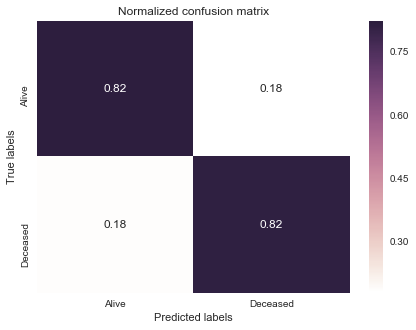

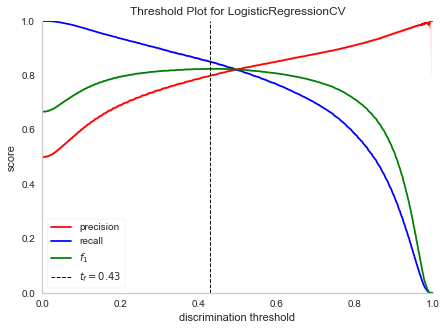

  Train Time: 107.670s 
 Validation scores are as follows:
 
 Recall Score:   0.8153803824460035
 Precision Score:   0.9020770039478121
 Accuracy Score:   0.8221777687444507
 F1 Score:   0.8473909526933622


In [50]:
# Resampling Data Set: SMOTETomek (Over + Under Sampling) + Logistic Regression CV
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state = 0)
print('Original dataset shape {}'.format(Counter(y_train)))
smt = SMOTETomek(ratio='auto')
t0 = time()
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_train_smt)))
estimator = LogisticRegressionCV()
t0 = time()
scores_smt = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
        
estimator.fit(X_train_smt, y_train_smt)
        
expected  = y_test
predicted = estimator.predict(X_test)
        
# Append our scores to the tracker
scores_smt['precision'].append(metrics.precision_score(expected, predicted, average='weighted'))
scores_smt['recall'].append(metrics.recall_score(expected, predicted))
scores_smt['accuracy'].append(metrics.accuracy_score(expected, predicted))
scores_smt['f1'].append(metrics.f1_score(expected, predicted, average='weighted'))
    
train_time_smt = time() - t0

cm = confusion_matrix(expected, predicted)
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); 
ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)
    
# Instantiate the classification model and visualizer
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red', 'blue', 'green'])
figsize=(7, 5)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(estimator, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
visualizer.fit(X_train_smt, y_train_smt)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data

smt_rec = scores_smt['recall'][0]
smt_pr = scores_smt['precision'][0]
smt_acc = scores_smt['accuracy'][0]
smt_f1 = scores_smt['f1'][0]
    
# Report
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_smt, color.END)
print(color.BOLD, "Validation scores are as follows:\n", color.END)
print(color.BOLD, 'Recall Score: ', color.END, smt_rec) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, smt_pr)
print(color.BOLD, 'Accuracy Score: ', color.END, smt_acc)
print(color.BOLD, 'F1 Score: ', color.END, smt_f1)

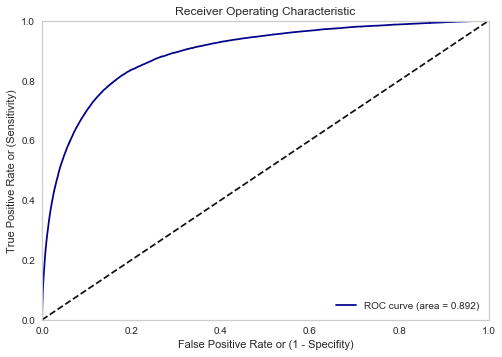

In [51]:
# Plotting ROC curve for SMOTETomek + Logistic Regression CV Model
y_pred_smt_proba = estimator.predict_proba(X_test)
y_pred_smt_proba[:5]
def plot_roc_curve(y_test, y_pred_smt_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_smt_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, color='darkblue')
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(False)
plot_roc_curve(y_test, y_pred_smt_proba)

Original dataset shape Counter({0: 660203, 1: 87644})
Resampled dataset shape Counter({0: 491184, 1: 436374})
[[142783  22372]
 [  6155  15652]]


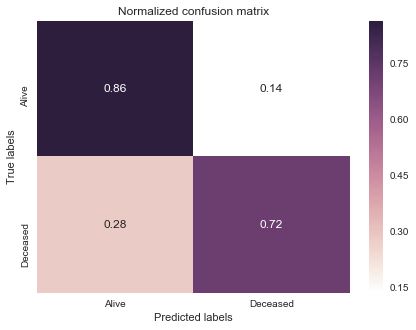

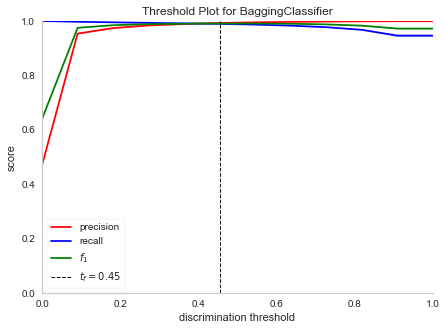

  Train Time: 1396.381s 
 Validation scores are as follows:
 
 Recall Score:   0.7177511808135002
 Precision Score:   0.8948681373077417
 Accuracy Score:   0.8474181919320504
 F1 Score:   0.8641576046603706


In [52]:
# Resampling Data Set: SMOTEENN (Over + Under Sampling) algorithm + Bagging Classifier
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state = 0)
print('Original dataset shape {}'.format(Counter(y_train)))
sme = SMOTEENN(random_state=42)
t0 = time()
X_train_sme, y_train_sme = sme.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_train_sme)))

estimator = BaggingClassifier()
scores_sme = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
        
estimator.fit(X_train_sme, y_train_sme)
        
expected  = y_test
predicted = estimator.predict(X_test)
        
# Append our scores to the tracker
scores_sme['precision'].append(metrics.precision_score(expected, predicted, average='weighted'))
scores_sme['recall'].append(metrics.recall_score(expected, predicted))
scores_sme['accuracy'].append(metrics.accuracy_score(expected, predicted))
scores_sme['f1'].append(metrics.f1_score(expected, predicted, average='weighted'))
    
train_time_sme = time() - t0

cm = confusion_matrix(expected, predicted)
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); 
ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)
    
# Instantiate the classification model and visualizer
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red', 'blue', 'green'])
figsize=(7, 5)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(estimator, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
visualizer.fit(X_train_sme, y_train_sme)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data

sme_rec = scores_sme['recall'][0]
sme_pr = scores_sme['precision'][0]
sme_acc = scores_sme['accuracy'][0]
sme_f1 = scores_sme['f1'][0]
    
# Report
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_sme, color.END)
print(color.BOLD, "Validation scores are as follows:\n", color.END)
print(color.BOLD, 'Recall Score: ', color.END, sme_rec) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, sme_pr)
print(color.BOLD, 'Accuracy Score: ', color.END, sme_acc)
print(color.BOLD, 'F1 Score: ', color.END, sme_f1)

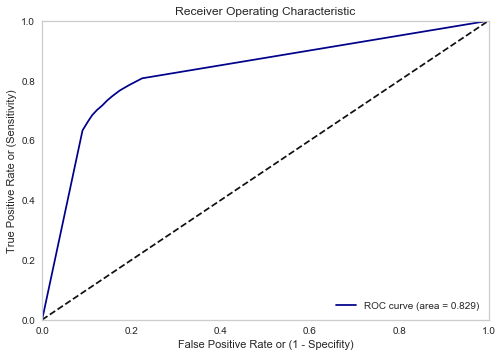

In [53]:
# Plotting ROC Curve for SMOTEENN + Bagging Classifier Model
y_pred_sme_proba = estimator.predict_proba(X_test)
y_pred_sme_proba[:5]
def plot_roc_curve(y_test, y_pred_sme_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_sme_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, color='darkblue')
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(False)
plot_roc_curve(y_test, y_pred_sme_proba)

### Model Selection

For model selection purposes we decided to focus on the recall score metric, since identifying the cases with positive mortality probability, i.e. true positives, was more important than identifying all true negative outcomes. However, we also considered f1, accuracy and precision scores, along with the amount of time it took to train the model.

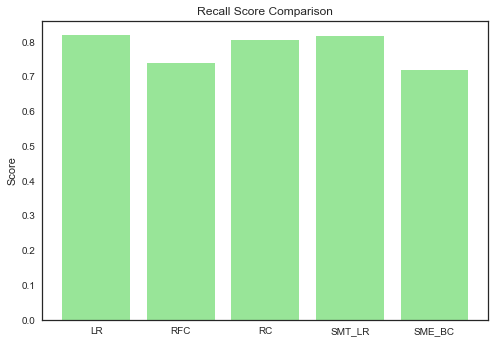

In [54]:
# Comparing Recall Scores for all models
mpl.style.use('seaborn-white')
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['limegreen'])

objects = ('LR', 'RFC', 'RC', 'SMT_LR', 'SME_BC')
y_pos = np.arange(len(objects))
performance = [lr_rec, rf_rec, rc_rec, smt_rec, sme_rec]
 
plt.bar(y_pos, performance, align='center', alpha=0.5, color='limegreen')
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('Recall Score Comparison')
plt.grid(False)
 
plt.show()

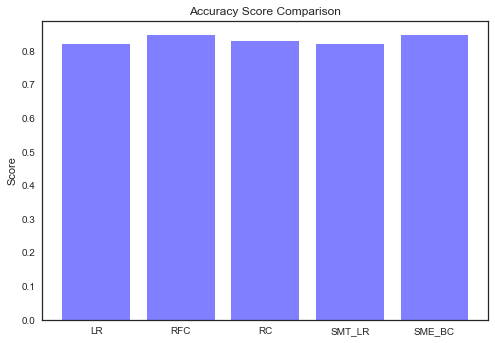

In [55]:
# Comparing Accuracy Scores
mpl.rcParams['axes.prop_cycle'] = cycler('color', [ 'blue'])

objects = ('LR', 'RFC', 'RC', 'SMT_LR', 'SME_BC')
y_pos = np.arange(len(objects))
performance = [lr_acc, rf_acc, rc_acc, smt_acc, sme_acc]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('Accuracy Score Comparison')
plt.grid(False)
 
plt.show()

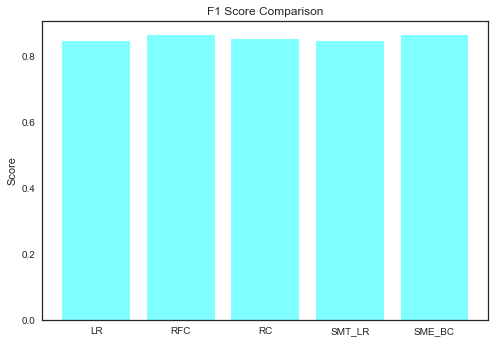

In [56]:
# Comparing F1 Scores
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['cyan'])

objects = ('LR', 'RFC', 'RC', 'SMT_LR', 'SME_BC')
y_pos = np.arange(len(objects))
performance = [lr_f1, rf_f1, rc_f1, smt_f1, sme_f1]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('F1 Score Comparison')
plt.grid(False)
 
plt.show()

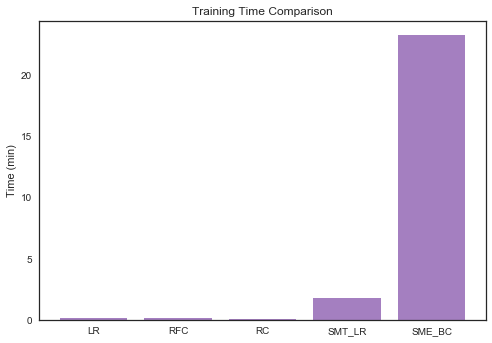

In [57]:
# Comparing Training time
mpl.style.use('seaborn-white')
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['indigo'])
objects = ('LR', 'RFC', 'RC', 'SMT_LR', 'SME_BC')
y_pos = np.arange(len(objects))
performance = [train_time_lr/60, train_time_rf/60, train_time_rc/60, train_time_smt/60, train_time_sme/60]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time (min)')
plt.title('Training Time Comparison')
plt.grid(False)
 
plt.show()

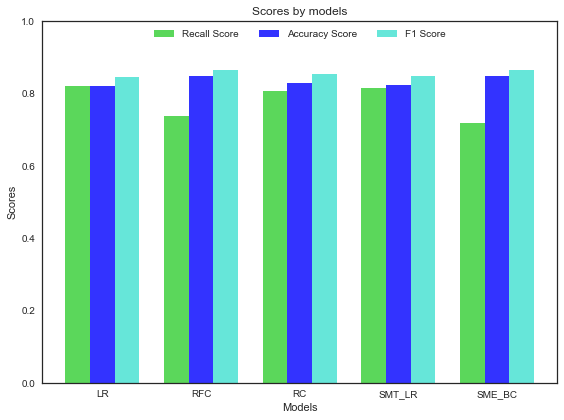

In [58]:
# Comparing Recall and Accuracy Scores for each model
mpl.style.use('seaborn-white')
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['limegreen', 'blue', 'turquoise'])
n_groups = 5
rec_sc = [lr_rec, rf_rec, rc_rec, smt_rec, sme_rec]
acc_sc = [lr_acc, rf_acc, rc_acc, smt_acc, sme_acc]
f1_sc = [lr_f1, rf_f1, rc_f1, smt_f1, sme_f1]
performance = [train_time_lr/60, train_time_rf/60, train_time_rc/60, train_time_smt/60, train_time_sme/60]
 
# Creating the plot
figsize=(8, 6)
fig, ax = plt.subplots(figsize=figsize)
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, rec_sc, bar_width,
                 alpha=opacity,
                 label='Recall Score')
 
rects2 = plt.bar(index + bar_width, acc_sc, bar_width,
                 alpha=opacity,
                 label='Accuracy Score')

rects3 = plt.bar(index + bar_width + bar_width, f1_sc, bar_width,
                 alpha=opacity,
                 label='F1 Score')
 
plt.xlabel('Models')
plt.ylabel('Scores')
plt.ylim(0, 1)
plt.title('Scores by models')
plt.xticks(index + bar_width, ('LR', 'RFC', 'RC', 'SMT_LR', 'SME_BC'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
plt.grid(False)
 
plt.tight_layout()
plt.show()

We can conclude from the chart above, that Logistic regression model produced pretty good results when account for all the scores we were comparing, and it's performance was basically instantaneous. We will be selecting this model and pickling it for future use.

In [67]:
# Pickling Logistic Regression Model
label = "Mortality Logistic Regression"
outpath = label.lower().replace(" ", "-") + ".pickle"
with open(outpath, 'wb') as f:
    pickle.dump(estimator_lr, f)

Since we are going to proceed with developing a web app, let's test predictive ability of our pickled model based on a user input.

In [68]:
# Predicting a new observation
user_input = {'age':77, 'sex':1, 'ms':'2', 'educ':'8', 'pob':'104', 'esr':'5', 'urban':'1', 'ssnyn':0, 'vt':0, 'histatus':1, 'hitype': '4'}
def input_to_one_hot(data):
    # initialize the target vector with zero values
    enc_input = np.zeros(40)
    # set the numerical input as they are
    enc_input[0] = data['age']
    enc_input[1] = data['sex']
    enc_input[2] = data['urban']
    enc_input[3] = data['ssnyn']
    enc_input[4] = data['vt']
    enc_input[5] = data['histatus']
    ##################### Marital Status ####################
    # get the array of marital status
    ms = df.ms.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'ms_'+data['ms']
    # search for the index in columns name list 
    ms_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[ms_column_index] = 1
    ##################### Education ####################
    # get the array of education
    educ = df.educ.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'educ_'+data['educ']
    # search for the index in columns name list 
    educ_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[educ_column_index] = 1
    ##################### POB ####################
    # get the array of place of birth
    pob = df.pob.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'pob_'+data['pob']
    # search for the index in columns name list 
    pob_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[pob_column_index] = 1
    ##################### Employment Status ####################
    # get the array of employment status
    esr = df.esr.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'esr_'+data['esr']
    # search for the index in columns name list 
    esr_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[esr_column_index] = 1
    ##################### Health Insurance Type ####################
    # get the array of HI Type
    hitype = df.hitype.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'hitype_'+data['hitype']
    # search for the index in columns name list 
    hitype_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[hitype_column_index] = 1
    return enc_input

In [69]:
print(input_to_one_hot(user_input))

[77.  1.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.]


In [70]:
a = input_to_one_hot(user_input)
a = a.reshape(1, -1)

In [71]:
joblib.dump(estimator_lr, 'mortality-logistic-regression.pkl')

['mortality-logistic-regression.pkl']

In [72]:
lr = joblib.load('mortality-logistic-regression.pkl')
mort = lr.predict_proba(a)
mort = np.around(mort, 2)
print("Probability of 11-year mortality is", mort[0,1])

Probability of 11-year mortality is 0.85


Check out live Mortality Predictor web app based on the pickled logistic regression model at this URL: https://mortality-predictor.herokuapp.com/!